# DiffuPath evaluation by Leaving Omics Out

In [3]:
import os 

import matplotlib.pyplot as plt

import networkx as nx

import pybel
from pybel_tools.summary import plot_summary, count_top_centrality

from diffupy.process_network import process_kernel_from_file
from diffupy.utils import from_json, to_json

from diffupath.constants import DEFAULT_DIFFUPATH_DIR, ROOT_RESULTS_DIR
from diffupath.utils import reduce_dict_dimension

## 1. PathMeUniverse graph and kernel import

##### Import graph

PathMe Universe v1.0.0
Number of Nodes: 42272
Number of Edges: 105871
Number of Citations: 7695
Number of Authors: 0
Network Density: 5.92E-05
Number of Components: 435
Number of Warnings: 0


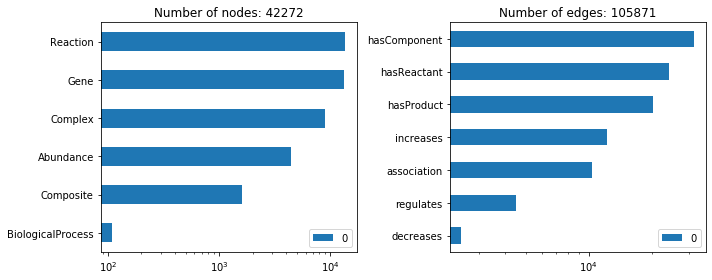

In [3]:
GRAPH_PATH = os.path.join(DEFAULT_DIFFUPATH_DIR, 'pickles', 'universe', 'pathme_universe_non_flatten_collapsed_names_no_isolates_16_03_2020.pickle')

pathme_universe_graph_no_flatten = pybel.from_pickle(GRAPH_PATH)
pathme_universe_graph_no_flatten.summarize()

nx.number_of_isolates(pathme_universe_graph_no_flatten)
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

##### Import kernel

In [ ]:
KERNEL_PATH = os.path.join(DEFAULT_DIFFUPATH_DIR, 'kernels', 'kernel_regularized_pathme_universe.pickle')

kernel = process_kernel_from_file(KERNEL_PATH)

## 2. Load/import preprocessed datasets mapping 

##### Dataset 1

In [6]:
MAPPING_PATH_DATASET_1 = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_1_mapping.json')

dataset1_mapping_by_database_and_entity = from_json(MAPPING_PATH_DATASET_1)

In [7]:
dataset1_mapping_by_database = reduce_dict_dimension(dataset1_mapping_by_database_and_entity)

dataset1_mapping_all_labels = {entity:entity_value for entity_type, entity_set in dataset1_mapping_by_database.items() for entity, entity_value in entity_set.items()}


In [8]:
dataset1_mapping_kegg = dataset1_mapping_by_database['kegg']

##### Dataset 2

In [9]:
MAPPING_PATH_DATASET2 = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_2_mapping.json')

dataset2_mapping_by_database_and_entity = from_json(MAPPING_PATH_DATASET2)

In [10]:
dataset2_mapping_by_database = reduce_dict_dimension(dataset2_mapping_by_database_and_entity)

dataset2_mapping_all_labels = {entity:entity_value for entity_type, entity_set in dataset2_mapping_by_database.items() for entity, entity_value in entity_set.items()}

In [11]:
dataset2_mapping_kegg = dataset2_mapping_by_database['kegg']

##### Dataset 3

In [12]:
MAPPING_PATH_DATASET3 = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_3_mapping.json')

dataset3_mapping_by_database_and_entity = from_json(MAPPING_PATH_DATASET3)

In [13]:
dataset3_mapping_by_database = reduce_dict_dimension(dataset3_mapping_by_database_and_entity)

dataset3_mapping_all_labels = {entity:entity_value for entity_type, entity_set in dataset3_mapping_by_database.items() for entity, entity_value in entity_set.items()}

## 3. Evaluation: random cross-validation by method

In [3]:
from diffupath.views import show_box_plot, fdr_barchart_three_plot

from diffupath.cross_validation import cross_validation_by_method, get_p_values, get_wilcoxon_test

from collections import defaultdict

In [4]:
metrics_by_method = defaultdict(lambda: defaultdict(lambda: list))

In [17]:
metrics_by_method['auroc']['Dataset 1'], metrics_by_method['auprc']['Dataset 1'] = cross_validation_by_method(dataset1_mapping_all_labels, 
                                                                                                              kernel, 
                                                                                                              kernel_kegg, 
                                                                                                              k = 3)

100%|██████████| 3/3 [00:36<00:00, 12.21s/it]


In [18]:
metrics_by_method['auroc']['Dataset 2'], metrics_by_method['auprc']['Dataset 2'] = cross_validation_by_method(dataset2_mapping_all_labels, 
                                                                                                               kernel, 
                                                                                                               kernel_kegg, 
                                                                                                               k = 3)

100%|██████████| 3/3 [00:34<00:00, 11.64s/it]


In [19]:
metrics_by_method['auroc']['Dataset 3'], metrics_by_method['auprc']['Dataset 3'] =  cross_validation_by_method(dataset3_mapping_all_labels, 
                                                                                                               kernel, 
                                                                                                               kernel_kegg, 
                                                                                                               k = 3)

100%|██████████| 3/3 [00:35<00:00, 11.81s/it]


### 3.1. Result metrics AUROC

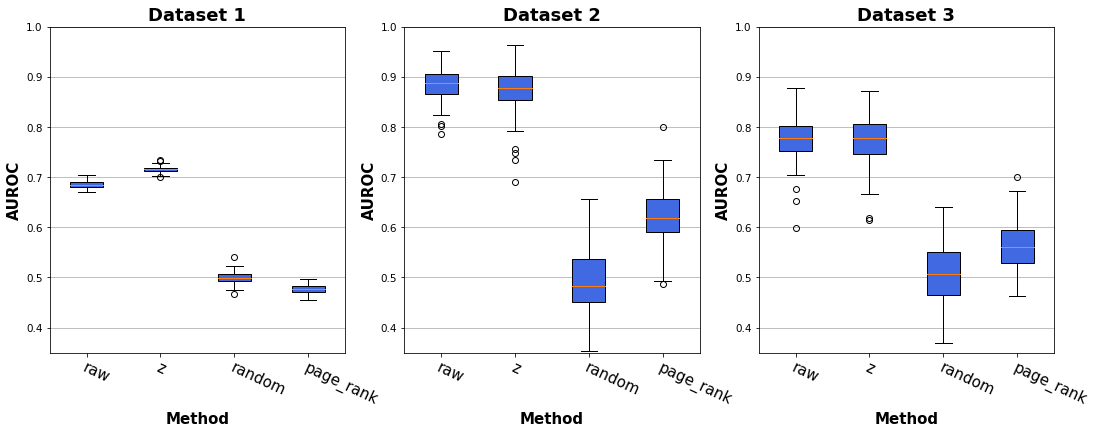

In [8]:
show_box_plot(metrics_by_method['auroc'], 'Method', 'AUROC', y_lim = [0.35, 1], color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])



##### Wilcoxon test

In [9]:
df_wilcoxon = get_wilcoxon_test(metrics_by_method['auroc'], True, "AUROC")
df_wilcoxon.style.hide_index()

Dataset,Comparison AUROC,p_value,Significant difference
Dataset 1,"('raw', 'z')",3.89656e-18,True
Dataset 1,"('raw', 'random')",3.89656e-18,True
Dataset 1,"('raw', 'page_rank')",3.89656e-18,True
Dataset 1,"('z', 'random')",3.89656e-18,True
Dataset 1,"('z', 'page_rank')",3.89656e-18,True
Dataset 1,"('random', 'page_rank')",8.77788e-18,True
Dataset 2,"('raw', 'z')",0.0040036,True
Dataset 2,"('raw', 'random')",3.89656e-18,True
Dataset 2,"('raw', 'page_rank')",3.89656e-18,True
Dataset 2,"('z', 'random')",3.89656e-18,True


### 3.2. Result metrics AUPRC

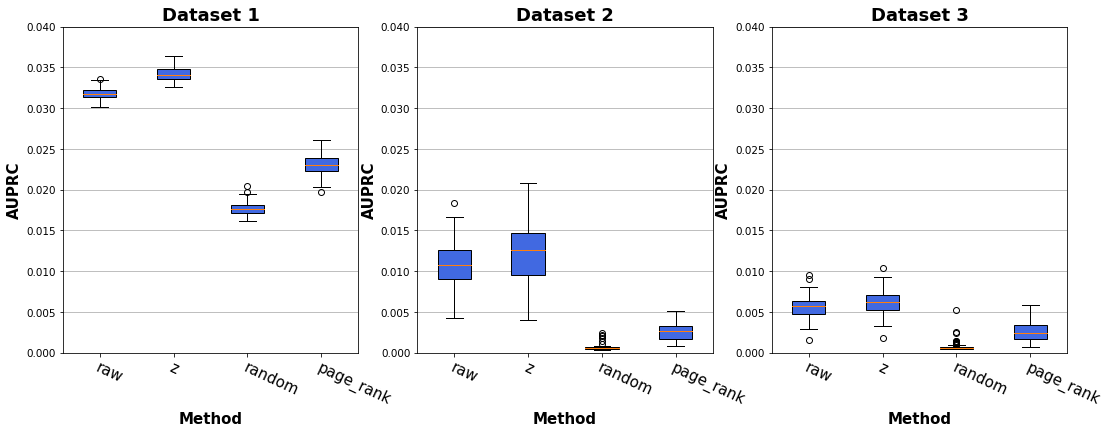

In [12]:
show_box_plot(metrics_by_method['auprc'], 'Method', 'AUPRC', y_lim = [0, 0.04],  color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])


##### Wilcoxon test

In [13]:
df_wilcoxon = get_wilcoxon_test(metrics_by_method['auprc'], True, "AUPRC")
df_wilcoxon.style.hide_index()

Dataset,Comparison AUPRC,p_value,Significant difference
Dataset 1,"('raw', 'z')",3.89656e-18,True
Dataset 1,"('raw', 'random')",3.89656e-18,True
Dataset 1,"('raw', 'page_rank')",3.89656e-18,True
Dataset 1,"('z', 'random')",3.89656e-18,True
Dataset 1,"('z', 'page_rank')",3.89656e-18,True
Dataset 1,"('random', 'page_rank')",3.89656e-18,True
Dataset 2,"('raw', 'z')",3.69817e-14,True
Dataset 2,"('raw', 'random')",3.89656e-18,True
Dataset 2,"('raw', 'page_rank')",3.89656e-18,True
Dataset 2,"('z', 'random')",3.89656e-18,True


### 3.3. Export evaluation by method to  .json file

In [1]:
OUTPUT_PATH = os.path.join(ROOT_RESULTS_DIR, 'outputs', 'metrics_by_method_validation.json')
to_json(metrics_by_method, OUTPUT_PATH)

NameError: name 'os' is not defined

## 4. Evaluation stratified by entity: random cross-validation by method

In [1]:
from diffupath.views import show_sb_box_plot, preprocess_for_sb_boxplot, fdr_barchart_three_plot, preprocess_for_sb_ttest

from diffupath.statistic_tests import get_p_values, get_wilcoxon_test

from collections import defaultdict


In [2]:
metrics_ltoo = {"auroc": {"Dataset 1": {"gene_nodes": {"merged": {"raw": [0.7020726551715974, 0.7020726551715974, 0.7020726551715974, 0.7020726551715974, 0.7020726551715974, 0.7020726551715974, 0.7020726551715974, 0.7020726551715974, 0.7020726551715974, 0.7020726551715974], "z": [0.6734745687308323, 0.6734745687308323, 0.6734745687308323, 0.6734745687308323, 0.6734745687308323, 0.6734745687308323, 0.6734745687308323, 0.6734745687308323, 0.6734745687308323, 0.6734745687308323], "random": [0.5576512574619585, 0.4889722598398265, 0.4913999217989187, 0.4080504666351577, 0.42644649552221264, 0.4285696793674038, 0.46346303447949344, 0.5678778038720147, 0.4335613245859139, 0.508564161211774], "page_rank": [0.704044008107444, 0.704044008107444, 0.704044008107444, 0.704044008107444, 0.704044008107444, 0.704044008107444, 0.704044008107444, 0.704044008107444, 0.704044008107444, 0.704044008107444]}, "mirna_nodes": {"raw": [0.839409496321181, 0.839409496321181, 0.839409496321181, 0.839409496321181, 0.839409496321181, 0.839409496321181, 0.839409496321181, 0.839409496321181, 0.839409496321181, 0.839409496321181], "z": [0.8371225563257549, 0.8371225563257549, 0.8371225563257549, 0.8371225563257549, 0.8371225563257549, 0.8371225563257549, 0.8371225563257549, 0.8371225563257549, 0.8371225563257549, 0.8371225563257549], "random": [0.5642038688715922, 0.1796746236406507, 0.5810010488379979, 0.5373047229253906, 0.6570694046858612, 0.45047986309904026, 0.6581892166836216, 0.13165676973668647, 0.5880353608239293, 0.6148871907702256], "page_rank": [0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708]}, "metabolite_nodes": {"raw": [0.521829669419532, 0.521829669419532, 0.521829669419532, 0.521829669419532, 0.521829669419532, 0.521829669419532, 0.521829669419532, 0.521829669419532, 0.521829669419532, 0.521829669419532], "z": [0.4144970484211829, 0.4144970484211829, 0.4144970484211829, 0.4144970484211829, 0.4144970484211829, 0.4144970484211829, 0.4144970484211829, 0.4144970484211829, 0.4144970484211829, 0.4144970484211829], "random": [0.4863324517126074, 0.48935593146293827, 0.5426026681617206, 0.4789202846184791, 0.42579550646471304, 0.4468379061720126, 0.5089712341658672, 0.5370399022875418, 0.45932500496025425, 0.37797683515755404], "page_rank": [0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756]}, "bp_nodes": {"raw": [0.8504333168901663, 0.8504333168901663, 0.8504333168901663, 0.8504333168901663, 0.8504333168901663, 0.8504333168901663, 0.8504333168901663, 0.8504333168901663, 0.8504333168901663, 0.8504333168901663], "z": [0.8945222410519743, 0.8945222410519743, 0.8945222410519743, 0.8945222410519743, 0.8945222410519743, 0.8945222410519743, 0.8945222410519743, 0.8945222410519743, 0.8945222410519743, 0.8945222410519743], "random": [0.361719943134553, 0.5450163551869698, 0.6267030964728497, 0.3749533554072233, 0.366458123622278, 0.469354730080256, 0.5662990314307194, 0.3682620179224453, 0.5677752759084547, 0.5710426727488183], "page_rank": [0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018]}}, "mirna_nodes": {"merged": {"raw": [0.5916372527414454, 0.5916372527414454, 0.5916372527414454, 0.5916372527414454, 0.5916372527414454, 0.5916372527414454, 0.5916372527414454, 0.5916372527414454, 0.5916372527414454, 0.5916372527414454], "z": [0.6093983004518173, 0.6093983004518173, 0.6093983004518173, 0.6093983004518173, 0.6093983004518173, 0.6093983004518173, 0.6093983004518173, 0.6093983004518173, 0.6093983004518173, 0.6093983004518173], "random": [0.49067238695476856, 0.5030966014230313, 0.49705046201978176, 0.5085681562549492, 0.49910964701723304, 0.49886940546977404, 0.5239650507083622, 0.49072867965504485, 0.5079867618168296, 0.4889200746710962], "page_rank": [0.4793105446829904, 0.4793105446829904, 0.4793105446829904, 0.4793105446829904, 0.4793105446829904, 0.4793105446829904, 0.4793105446829904, 0.4793105446829904, 0.4793105446829904, 0.4793105446829904]}, "gene_nodes": {"raw": [0.5927297352140183, 0.5927297352140183, 0.5927297352140183, 0.5927297352140183, 0.5927297352140183, 0.5927297352140183, 0.5927297352140183, 0.5927297352140183, 0.5927297352140183, 0.5927297352140183], "z": [0.6159915297762237, 0.6159915297762237, 0.6159915297762237, 0.6159915297762237, 0.6159915297762237, 0.6159915297762237, 0.6159915297762237, 0.6159915297762237, 0.6159915297762237, 0.6159915297762237], "random": [0.5003092249876734, 0.5205123043368933, 0.4916518980812554, 0.49233949705316765, 0.5156722770938993, 0.49048381169663247, 0.5083625254300341, 0.49398535386349096, 0.4909186302474348, 0.4973764723113614], "page_rank": [0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823]}, "metabolite_nodes": {"raw": [0.4842846403224075, 0.4842846403224075, 0.4842846403224075, 0.4842846403224075, 0.4842846403224075, 0.4842846403224075, 0.4842846403224075, 0.4842846403224075, 0.4842846403224075, 0.4842846403224075], "z": [0.2655092133309791, 0.2655092133309791, 0.2655092133309791, 0.2655092133309791, 0.2655092133309791, 0.2655092133309791, 0.2655092133309791, 0.2655092133309791, 0.2655092133309791, 0.2655092133309791], "random": [0.4634806968747668, 0.5327986573638388, 0.5130286311336503, 0.5132142993663618, 0.4261377185014754, 0.34298383412181654, 0.49044081643054643, 0.5653288239009624, 0.3618637450010649, 0.40468575651613586], "page_rank": [0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756]}, "bp_nodes": {"raw": [0.5676897228992641, 0.5676897228992641, 0.5676897228992641, 0.5676897228992641, 0.5676897228992641, 0.5676897228992641, 0.5676897228992641, 0.5676897228992641, 0.5676897228992641, 0.5676897228992641], "z": [0.22250335385998798, 0.22250335385998798, 0.22250335385998798, 0.22250335385998798, 0.22250335385998798, 0.22250335385998798, 0.22250335385998798, 0.22250335385998798, 0.22250335385998798, 0.22250335385998798], "random": [0.5815474901113463, 0.4602733691685158, 0.507318422839377, 0.6894680605132817, 0.5537263796332871, 0.4510627686045941, 0.5599899520721121, 0.44762972657622313, 0.4639648905012496, 0.3897958923633928], "page_rank": [0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018]}}, "metabolite_nodes": {"merged": {"raw": [0.4917663353509792, 0.4917663353509792, 0.4917663353509792, 0.4917663353509792, 0.4917663353509792, 0.4917663353509792, 0.4917663353509792, 0.4917663353509792, 0.4917663353509792, 0.4917663353509792], "z": [0.4805214207835916, 0.4805214207835916, 0.4805214207835916, 0.4805214207835916, 0.4805214207835916, 0.4805214207835916, 0.4805214207835916, 0.4805214207835916, 0.4805214207835916, 0.4805214207835916], "random": [0.5009517591424932, 0.5102837701893552, 0.5112013159577301, 0.5234100884062634, 0.5039011627651278, 0.4883564079293042, 0.49047038451998753, 0.4954526583741901, 0.501592693556791, 0.5181883126350579], "page_rank": [0.4761859730476947, 0.4761859730476947, 0.4761859730476947, 0.4761859730476947, 0.4761859730476947, 0.4761859730476947, 0.4761859730476947, 0.4761859730476947, 0.4761859730476947, 0.4761859730476947]}, "gene_nodes": {"raw": [0.48748275698575516, 0.48748275698575516, 0.48748275698575516, 0.48748275698575516, 0.48748275698575516, 0.48748275698575516, 0.48748275698575516, 0.48748275698575516, 0.48748275698575516, 0.48748275698575516], "z": [0.4773104498624408, 0.4773104498624408, 0.4773104498624408, 0.4773104498624408, 0.4773104498624408, 0.4773104498624408, 0.4773104498624408, 0.4773104498624408, 0.4773104498624408, 0.4773104498624408], "random": [0.5056520625428271, 0.498596651051874, 0.5008694945436444, 0.4985063028480179, 0.500626408063843, 0.49426832302916013, 0.500881989329587, 0.5032161662873871, 0.5088048240808773, 0.5026673852258733], "page_rank": [0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823]}, "mirna_nodes": {"raw": [0.7141246145717508, 0.7141246145717508, 0.7141246145717508, 0.7141246145717508, 0.7141246145717508, 0.7141246145717508, 0.7141246145717508, 0.7141246145717508, 0.7141246145717508, 0.7141246145717508], "z": [0.597845544804309, 0.597845544804309, 0.597845544804309, 0.597845544804309, 0.597845544804309, 0.597845544804309, 0.597845544804309, 0.597845544804309, 0.597845544804309, 0.597845544804309], "random": [0.4200635611598728, 0.754390530491219, 0.671587530656825, 0.7931975364136049, 0.3952384332095231, 0.33114891133770213, 0.7779144684441711, 0.5791162948417673, 0.5062417689875165, 0.4351573651296853], "page_rank": [0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708]}, "bp_nodes": {"raw": [0.9060555148015808, 0.9060555148015808, 0.9060555148015808, 0.9060555148015808, 0.9060555148015808, 0.9060555148015808, 0.9060555148015808, 0.9060555148015808, 0.9060555148015808, 0.9060555148015808], "z": [0.8035994153270947, 0.8035994153270947, 0.8035994153270947, 0.8035994153270947, 0.8035994153270947, 0.8035994153270947, 0.8035994153270947, 0.8035994153270947, 0.8035994153270947, 0.8035994153270947], "random": [0.5100852435621361, 0.46687733336731185, 0.5052869939402986, 0.35503588675694026, 0.47932256578935395, 0.5397047875099888, 0.45871339195838123, 0.5066540218105565, 0.6319509544621356, 0.4956595499911717], "page_rank": [0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018, 0.6896519084692018]}}, "bp_nodes": {"merged": {"raw": [0.5347257698071413, 0.5347257698071413, 0.5347257698071413, 0.5347257698071413, 0.5347257698071413, 0.5347257698071413, 0.5347257698071413, 0.5347257698071413, 0.5347257698071413, 0.5347257698071413], "z": [0.5320177268926332, 0.5320177268926332, 0.5320177268926332, 0.5320177268926332, 0.5320177268926332, 0.5320177268926332, 0.5320177268926332, 0.5320177268926332, 0.5320177268926332, 0.5320177268926332], "random": [0.5130338848493835, 0.4856905529347615, 0.4878601604883575, 0.49159669576642895, 0.4995541639701056, 0.5058189539105271, 0.5007760701886166, 0.5012280219732346, 0.49062341945704546, 0.4946440344463869], "page_rank": [0.47716129070804425, 0.47716129070804425, 0.47716129070804425, 0.47716129070804425, 0.47716129070804425, 0.47716129070804425, 0.47716129070804425, 0.47716129070804425, 0.47716129070804425, 0.47716129070804425]}, "gene_nodes": {"raw": [0.5317314732639002, 0.5317314732639002, 0.5317314732639002, 0.5317314732639002, 0.5317314732639002, 0.5317314732639002, 0.5317314732639002, 0.5317314732639002, 0.5317314732639002, 0.5317314732639002], "z": [0.5297717541393088, 0.5297717541393088, 0.5297717541393088, 0.5297717541393088, 0.5297717541393088, 0.5297717541393088, 0.5297717541393088, 0.5297717541393088, 0.5297717541393088, 0.5297717541393088], "random": [0.48807786938440506, 0.5037969138750842, 0.5030107318806609, 0.5113329301794213, 0.500650458430342, 0.5086658552267559, 0.4935831391568126, 0.4937118773808333, 0.49702311305629493, 0.504247179000186], "page_rank": [0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823, 0.47447535777477823]}, "mirna_nodes": {"raw": [0.6911605826176789, 0.6911605826176789, 0.6911605826176789, 0.6911605826176789, 0.6911605826176789, 0.6911605826176789, 0.6911605826176789, 0.6911605826176789, 0.6911605826176789, 0.6911605826176789], "z": [0.4414819371170362, 0.4414819371170362, 0.4414819371170362, 0.4414819371170362, 0.4414819371170362, 0.4414819371170362, 0.4414819371170362, 0.4414819371170362, 0.4414819371170362, 0.4414819371170362], "random": [0.4839007310321985, 0.3547832532904335, 0.3593729052812542, 0.5926092408147815, 0.6970671966058656, 0.6699551286600898, 0.33741828132516344, 0.45324784909350424, 0.6659884706680231, 0.28422721143154556], "page_rank": [0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708, 0.3645145772709708]}, "metabolite_nodes": {"raw": [0.82063902637035, 0.82063902637035, 0.82063902637035, 0.82063902637035, 0.82063902637035, 0.82063902637035, 0.82063902637035, 0.82063902637035, 0.82063902637035, 0.82063902637035], "z": [0.7939501280564722, 0.7939501280564722, 0.7939501280564722, 0.7939501280564722, 0.7939501280564722, 0.7939501280564722, 0.7939501280564722, 0.7939501280564722, 0.7939501280564722, 0.7939501280564722], "random": [0.33493457015073713, 0.4383590568781889, 0.5098285845345643, 0.46764549017323576, 0.5203661668793357, 0.31697207877429845, 0.670031144935899, 0.4638465725098158, 0.4681642690587531, 0.5553100204417084], "page_rank": [0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756, 0.7966241146628756]}}}, "Dataset 2": {"gene_nodes": {"merged": {"raw": [0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937], "z": [0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478], "random": [0.475595491639791, 0.6202020919115906, 0.5584352582435785, 0.34216344496054846, 0.3915725171227088, 0.526777685374874, 0.5951535803871456, 0.3608682717727159, 0.4816501355618209, 0.4849749497981785], "page_rank": [0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234]}, "metabolite_nodes": {"raw": [0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937, 0.8548677173552937], "z": [0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478, 0.8397158948770478], "random": [0.5384170706476542, 0.4716520286944822, 0.5664066989851457, 0.46218636538812596, 0.426311501457036, 0.5920349823871051, 0.4705939027605931, 0.40594004178414234, 0.41624071181788064, 0.4872348769125711], "page_rank": [0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234, 0.5942349039573234]}}, "metabolite_nodes": {"merged": {"raw": [0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642], "z": [0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194], "random": [0.45725851177512955, 0.46552933975408173, 0.4943601458195247, 0.40231410715976573, 0.4698993601796367, 0.47078536935084614, 0.5113845415071624, 0.5973883019735685, 0.48169900712865393, 0.53858620666333], "page_rank": [0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121]}, "gene_nodes": {"raw": [0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642, 0.8038301297225642], "z": [0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194, 0.6780751619841194], "random": [0.4923615526127126, 0.42519647760628726, 0.4667729652224492, 0.40809768420198306, 0.5288037523502914, 0.4660763320572998, 0.5021456977829482, 0.5229609953061803, 0.45117818929484493, 0.5852141301554236], "page_rank": [0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121, 0.6297838577245121]}}}, "Dataset 3": {"gene_nodes": {"merged": {"raw": [0.59811182358091, 0.59811182358091, 0.59811182358091, 0.59811182358091, 0.59811182358091, 0.59811182358091, 0.59811182358091, 0.59811182358091, 0.59811182358091, 0.59811182358091], "z": [0.4465871119208554, 0.4465871119208554, 0.4465871119208554, 0.4465871119208554, 0.4465871119208554, 0.4465871119208554, 0.4465871119208554, 0.4465871119208554, 0.4465871119208554, 0.4465871119208554], "random": [0.4299610639198458, 0.523139494225314, 0.3443069456603754, 0.5178130594925427, 0.4698830340171466, 0.5947098460171361, 0.5045521824974302, 0.5628879476926232, 0.4119284795999653, 0.5283081865671838], "page_rank": [0.6824645671154437, 0.6824645671154437, 0.6824645671154437, 0.6824645671154437, 0.6824645671154437, 0.6824645671154437, 0.6824645671154437, 0.6824645671154437, 0.6824645671154437, 0.6824645671154437]}, "metabolite_nodes": {"raw": [0.6235980976717774, 0.6235980976717774, 0.6235980976717774, 0.6235980976717774, 0.6235980976717774, 0.6235980976717774, 0.6235980976717774, 0.6235980976717774, 0.6235980976717774, 0.6235980976717774], "z": [0.3958836125307591, 0.3958836125307591, 0.3958836125307591, 0.3958836125307591, 0.3958836125307591, 0.3958836125307591, 0.3958836125307591, 0.3958836125307591, 0.3958836125307591, 0.3958836125307591], "random": [0.488985898163922, 0.5457866032557259, 0.6272418606852168, 0.642500118303994, 0.499393692031043, 0.4257287526026879, 0.676755039750142, 0.5422552290365323, 0.41890852735188344, 0.5490163022903654], "page_rank": [0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393]}, "mirna_nodes": {"raw": [0.39421825838045, 0.39421825838045, 0.39421825838045, 0.39421825838045, 0.39421825838045, 0.39421825838045, 0.39421825838045, 0.39421825838045, 0.39421825838045, 0.39421825838045], "z": [0.8521681531073314, 0.8521681531073314, 0.8521681531073314, 0.8521681531073314, 0.8521681531073314, 0.8521681531073314, 0.8521681531073314, 0.8521681531073314, 0.8521681531073314, 0.8521681531073314], "random": [0.9807669560691727, 0.40670909133921596, 0.8858792079676374, 0.8475787182702089, 0.09739537744553006, 0.3020510515483429, 0.12583094793120575, 0.23060727212509757, 0.6032031416337442, 0.2514489839369781], "page_rank": [0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541]}}, "metabolite_nodes": {"merged": {"raw": [0.42510716583617203, 0.42510716583617203, 0.42510716583617203, 0.42510716583617203, 0.42510716583617203, 0.42510716583617203, 0.42510716583617203, 0.42510716583617203, 0.42510716583617203, 0.42510716583617203], "z": [0.43494845734117316, 0.43494845734117316, 0.43494845734117316, 0.43494845734117316, 0.43494845734117316, 0.43494845734117316, 0.43494845734117316, 0.43494845734117316, 0.43494845734117316, 0.43494845734117316], "random": [0.46532743027605467, 0.4880007687529768, 0.4789268375563683, 0.48461379911593405, 0.5074688808237913, 0.5351530403344632, 0.5715504299167463, 0.5275553376803158, 0.47134654325767433, 0.4550133278369352], "page_rank": [0.5214725101177362, 0.5214725101177362, 0.5214725101177362, 0.5214725101177362, 0.5214725101177362, 0.5214725101177362, 0.5214725101177362, 0.5214725101177362, 0.5214725101177362, 0.5214725101177362]}, "gene_nodes": {"raw": [0.4301611249692407, 0.4301611249692407, 0.4301611249692407, 0.4301611249692407, 0.4301611249692407, 0.4301611249692407, 0.4301611249692407, 0.4301611249692407, 0.4301611249692407, 0.4301611249692407], "z": [0.4250373236854924, 0.4250373236854924, 0.4250373236854924, 0.4250373236854924, 0.4250373236854924, 0.4250373236854924, 0.4250373236854924, 0.4250373236854924, 0.4250373236854924, 0.4250373236854924], "random": [0.53944042809783, 0.5192515605640917, 0.5420159596868326, 0.5283347932795126, 0.45474633166103134, 0.5505711725555945, 0.5194804169921953, 0.4282341394962433, 0.5545879974488606, 0.5260304457965388], "page_rank": [0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528]}, "mirna_nodes": {"raw": [0.2585697049986989, 0.2585697049986989, 0.2585697049986989, 0.2585697049986989, 0.2585697049986989, 0.2585697049986989, 0.2585697049986989, 0.2585697049986989, 0.2585697049986989, 0.2585697049986989], "z": [0.7618698398429182, 0.7618698398429182, 0.7618698398429182, 0.7618698398429182, 0.7618698398429182, 0.7618698398429182, 0.7618698398429182, 0.7618698398429182, 0.7618698398429182, 0.7618698398429182], "random": [0.038773627309502956, 0.8804617823093847, 0.5028033403515413, 0.1002815168791843, 0.8549360081379669, 0.4952094816777459, 0.39670223084384093, 0.45250881218802486, 0.701473823661612, 0.5825979986279008], "page_rank": [0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541, 0.11388422322632541]}}, "mirna_nodes": {"merged": {"raw": [0.5528154961879235, 0.5528154961879235, 0.5528154961879235, 0.5528154961879235, 0.5528154961879235, 0.5528154961879235, 0.5528154961879235, 0.5528154961879235, 0.5528154961879235, 0.5528154961879235], "z": [0.42494272211316275, 0.42494272211316275, 0.42494272211316275, 0.42494272211316275, 0.42494272211316275, 0.42494272211316275, 0.42494272211316275, 0.42494272211316275, 0.42494272211316275, 0.42494272211316275], "random": [0.5722325121240841, 0.4171770708259047, 0.4974463909589014, 0.5310686693568648, 0.46492375558123694, 0.5045270755328851, 0.5161022044261787, 0.5407760222377389, 0.4297935108355843, 0.4806924285766265], "page_rank": [0.5767457266104948, 0.5767457266104948, 0.5767457266104948, 0.5767457266104948, 0.5767457266104948, 0.5767457266104948, 0.5767457266104948, 0.5767457266104948, 0.5767457266104948, 0.5767457266104948]}, "gene_nodes": {"raw": [0.55312159450515, 0.55312159450515, 0.55312159450515, 0.55312159450515, 0.55312159450515, 0.55312159450515, 0.55312159450515, 0.55312159450515, 0.55312159450515, 0.55312159450515], "z": [0.44975094824759826, 0.44975094824759826, 0.44975094824759826, 0.44975094824759826, 0.44975094824759826, 0.44975094824759826, 0.44975094824759826, 0.44975094824759826, 0.44975094824759826, 0.44975094824759826], "random": [0.47330737714032767, 0.5969752210903753, 0.480180244166134, 0.5876516532545322, 0.4383561938665042, 0.459841436213983, 0.5671090985137246, 0.5165088705181984, 0.5106324974693071, 0.5932331673944876], "page_rank": [0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528, 0.5338320107727528]}, "metabolite_nodes": {"raw": [0.5514711101646792, 0.5514711101646792, 0.5514711101646792, 0.5514711101646792, 0.5514711101646792, 0.5514711101646792, 0.5514711101646792, 0.5514711101646792, 0.5514711101646792, 0.5514711101646792], "z": [0.32278653227332954, 0.32278653227332954, 0.32278653227332954, 0.32278653227332954, 0.32278653227332954, 0.32278653227332954, 0.32278653227332954, 0.32278653227332954, 0.32278653227332954, 0.32278653227332954], "random": [0.6493262587544956, 0.595500899110354, 0.40347281374219196, 0.2595412171114897, 0.4885008517887564, 0.4283432708688245, 0.43589993848192315, 0.35877164963089153, 0.5853799924285443, 0.488441699791785], "page_rank": [0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393, 0.7535402470187393]}}}}, "auprc": {"Dataset 1": {"gene_nodes": {"merged": {"raw": [0.001303816403617114, 0.001303816403617114, 0.001303816403617114, 0.001303816403617114, 0.001303816403617114, 0.001303816403617114, 0.001303816403617114, 0.001303816403617114, 0.001303816403617114, 0.001303816403617114], "z": [0.0016382275013930873, 0.0016382275013930873, 0.0016382275013930873, 0.0016382275013930873, 0.0016382275013930873, 0.0016382275013930873, 0.0016382275013930873, 0.0016382275013930873, 0.0016382275013930873, 0.0016382275013930873], "random": [0.0008201194476005294, 0.0007367503527933591, 0.0007081267625377678, 0.0005906088785038925, 0.0006467746253617279, 0.0007105325923164256, 0.0006712413410497378, 0.0010133405818149694, 0.0006347648660876887, 0.0007459069125079372], "page_rank": [0.021438522490219936, 0.021438522490219936, 0.021438522490219936, 0.021438522490219936, 0.021438522490219936, 0.021438522490219936, 0.021438522490219936, 0.021438522490219936, 0.021438522490219936, 0.021438522490219936]}, "mirna_nodes": {"raw": [0.00029038328878786825, 0.00029038328878786825, 0.00029038328878786825, 0.00029038328878786825, 0.00029038328878786825, 0.00029038328878786825, 0.00029038328878786825, 0.00029038328878786825, 0.00029038328878786825, 0.00029038328878786825], "z": [0.0002849215129751338, 0.0002849215129751338, 0.0002849215129751338, 0.0002849215129751338, 0.0002849215129751338, 0.0002849215129751338, 0.0002849215129751338, 0.0002849215129751338, 0.0002849215129751338, 0.0002849215129751338], "random": [0.00015199280603497828, 5.55959265790266e-05, 0.00013882435288781067, 0.00015982770944936647, 0.0001989610426225717, 8.60230078082589e-05, 0.00013725183303143815, 5.3343861100008214e-05, 0.0001700133124564671, 0.0001209922685834167], "page_rank": [9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05]}, "metabolite_nodes": {"raw": [0.00033249957300526383, 0.00033249957300526383, 0.00033249957300526383, 0.00033249957300526383, 0.00033249957300526383, 0.00033249957300526383, 0.00033249957300526383, 0.00033249957300526383, 0.00033249957300526383, 0.00033249957300526383], "z": [0.00029222370169963095, 0.00029222370169963095, 0.00029222370169963095, 0.00029222370169963095, 0.00029222370169963095, 0.00029222370169963095, 0.00029222370169963095, 0.00029222370169963095, 0.00029222370169963095, 0.00029222370169963095], "random": [0.0008204658041532913, 0.0003246636362745413, 0.0005381048472128665, 0.0005213741276353537, 0.00045215491425741714, 0.00028073194348600866, 0.0005335470821860133, 0.0004403319695657678, 0.00039446961426245665, 0.0002493065908267376], "page_rank": [0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515]}, "bp_nodes": {"raw": [0.0010636317213975188, 0.0010636317213975188, 0.0010636317213975188, 0.0010636317213975188, 0.0010636317213975188, 0.0010636317213975188, 0.0010636317213975188, 0.0010636317213975188, 0.0010636317213975188, 0.0010636317213975188], "z": [0.001774551420430614, 0.001774551420430614, 0.001774551420430614, 0.001774551420430614, 0.001774551420430614, 0.001774551420430614, 0.001774551420430614, 0.001774551420430614, 0.001774551420430614, 0.001774551420430614], "random": [0.0002409585546904405, 0.0004388876645920182, 0.000471546328218815, 0.0004273566405975264, 0.00026534694644471255, 0.00038149498429033475, 0.0004513039102130511, 0.00024093448564822806, 0.00040348735088166265, 0.0005854765630507489], "page_rank": [0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382]}}, "mirna_nodes": {"merged": {"raw": [0.057300256042247824, 0.057300256042247824, 0.057300256042247824, 0.057300256042247824, 0.057300256042247824, 0.057300256042247824, 0.057300256042247824, 0.057300256042247824, 0.057300256042247824, 0.057300256042247824], "z": [0.06281583107645104, 0.06281583107645104, 0.06281583107645104, 0.06281583107645104, 0.06281583107645104, 0.06281583107645104, 0.06281583107645104, 0.06281583107645104, 0.06281583107645104, 0.06281583107645104], "random": [0.0342312816135145, 0.03568319573608663, 0.03500871404312024, 0.03621510329997633, 0.03512210357330895, 0.034942276631048694, 0.03805237468249662, 0.033384406555028646, 0.03699786644160721, 0.033825359945897165], "page_rank": [0.046616886543949715, 0.046616886543949715, 0.046616886543949715, 0.046616886543949715, 0.046616886543949715, 0.046616886543949715, 0.046616886543949715, 0.046616886543949715, 0.046616886543949715, 0.046616886543949715]}, "gene_nodes": {"raw": [0.056946569040037184, 0.056946569040037184, 0.056946569040037184, 0.056946569040037184, 0.056946569040037184, 0.056946569040037184, 0.056946569040037184, 0.056946569040037184, 0.056946569040037184, 0.056946569040037184], "z": [0.0627941010830739, 0.0627941010830739, 0.0627941010830739, 0.0627941010830739, 0.0627941010830739, 0.0627941010830739, 0.0627941010830739, 0.0627941010830739, 0.0627941010830739, 0.0627941010830739], "random": [0.0358086909264176, 0.03671415521219336, 0.03369237009876083, 0.03306894286533347, 0.037709771145543955, 0.0345670714459744, 0.036195673115325636, 0.034119522195825244, 0.03476960627009328, 0.03417021985076702], "page_rank": [0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846]}, "metabolite_nodes": {"raw": [0.00039656659463854294, 0.00039656659463854294, 0.00039656659463854294, 0.00039656659463854294, 0.00039656659463854294, 0.00039656659463854294, 0.00039656659463854294, 0.00039656659463854294, 0.00039656659463854294, 0.00039656659463854294], "z": [0.00027956325883273577, 0.00027956325883273577, 0.00027956325883273577, 0.00027956325883273577, 0.00027956325883273577, 0.00027956325883273577, 0.00027956325883273577, 0.00027956325883273577, 0.00027956325883273577, 0.00027956325883273577], "random": [0.0004867228002196193, 0.00040366662294248656, 0.0005870598384718249, 0.0003292085913056698, 0.0002801365638153531, 0.00023073055162076272, 0.0009306743169361336, 0.00046342044207661997, 0.0002763112436106305, 0.0004923678167053095], "page_rank": [0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515]}, "bp_nodes": {"raw": [0.00035991770315493984, 0.00035991770315493984, 0.00035991770315493984, 0.00035991770315493984, 0.00035991770315493984, 0.00035991770315493984, 0.00035991770315493984, 0.00035991770315493984, 0.00035991770315493984, 0.00035991770315493984], "z": [0.0002433333890005434, 0.0002433333890005434, 0.0002433333890005434, 0.0002433333890005434, 0.0002433333890005434, 0.0002433333890005434, 0.0002433333890005434, 0.0002433333890005434, 0.0002433333890005434, 0.0002433333890005434], "random": [0.0005076109799971846, 0.00029306812383796, 0.0003444716407901053, 0.0006161568490406942, 0.0004805625670363539, 0.0003317981589013873, 0.0005744134765606405, 0.0003831744815711455, 0.00031709803184063997, 0.0002782993261751796], "page_rank": [0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382]}}, "metabolite_nodes": {"merged": {"raw": [0.03551250036954661, 0.03551250036954661, 0.03551250036954661, 0.03551250036954661, 0.03551250036954661, 0.03551250036954661, 0.03551250036954661, 0.03551250036954661, 0.03551250036954661, 0.03551250036954661], "z": [0.03637519531886055, 0.03637519531886055, 0.03637519531886055, 0.03637519531886055, 0.03637519531886055, 0.03637519531886055, 0.03637519531886055, 0.03637519531886055, 0.03637519531886055, 0.03637519531886055], "random": [0.034623113459970614, 0.035832338517011196, 0.03693304694982312, 0.03697258705494943, 0.03565216681427034, 0.03366178261740736, 0.03385879557327004, 0.035510402072953876, 0.035094057988263906, 0.03798416257898077], "page_rank": [0.04500665334275635, 0.04500665334275635, 0.04500665334275635, 0.04500665334275635, 0.04500665334275635, 0.04500665334275635, 0.04500665334275635, 0.04500665334275635, 0.04500665334275635, 0.04500665334275635]}, "gene_nodes": {"raw": [0.03444908468598344, 0.03444908468598344, 0.03444908468598344, 0.03444908468598344, 0.03444908468598344, 0.03444908468598344, 0.03444908468598344, 0.03444908468598344, 0.03444908468598344, 0.03444908468598344], "z": [0.03513774377411563, 0.03513774377411563, 0.03513774377411563, 0.03513774377411563, 0.03513774377411563, 0.03513774377411563, 0.03513774377411563, 0.03513774377411563, 0.03513774377411563, 0.03513774377411563], "random": [0.03518049357311151, 0.034852898570227435, 0.0348683914397893, 0.03461732117565241, 0.034860371167365505, 0.03459282489775608, 0.03358956734770998, 0.03525271651003614, 0.035839187362948895, 0.03520166275078574], "page_rank": [0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846]}, "mirna_nodes": {"raw": [0.00017615435517061908, 0.00017615435517061908, 0.00017615435517061908, 0.00017615435517061908, 0.00017615435517061908, 0.00017615435517061908, 0.00017615435517061908, 0.00017615435517061908, 0.00017615435517061908, 0.00017615435517061908], "z": [0.00014716855277095974, 0.00014716855277095974, 0.00014716855277095974, 0.00014716855277095974, 0.00014716855277095974, 0.00014716855277095974, 0.00014716855277095974, 0.00014716855277095974, 0.00014716855277095974, 0.00014716855277095974], "random": [8.746803823506604e-05, 0.00026326002250560374, 0.001354146171779738, 0.0008984854091818263, 7.48426112021839e-05, 6.898744720374011e-05, 0.0002188783429134627, 0.0001108151786630077, 9.735204794947494e-05, 8.109687245533837e-05], "page_rank": [9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05]}, "bp_nodes": {"raw": [0.0028475959590855927, 0.0028475959590855927, 0.0028475959590855927, 0.0028475959590855927, 0.0028475959590855927, 0.0028475959590855927, 0.0028475959590855927, 0.0028475959590855927, 0.0028475959590855927, 0.0028475959590855927], "z": [0.005059719125892494, 0.005059719125892494, 0.005059719125892494, 0.005059719125892494, 0.005059719125892494, 0.005059719125892494, 0.005059719125892494, 0.005059719125892494, 0.005059719125892494, 0.005059719125892494], "random": [0.0003612820356859066, 0.0003238577649270016, 0.0003232830898750314, 0.0002508175484868526, 0.0003103295151255131, 0.00038204017453041496, 0.0011205289635310071, 0.00041557865914985573, 0.0008659177886099077, 0.0067548308281017745], "page_rank": [0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382, 0.0017535563620269382]}}, "bp_nodes": {"merged": {"raw": [0.045930562581363944, 0.045930562581363944, 0.045930562581363944, 0.045930562581363944, 0.045930562581363944, 0.045930562581363944, 0.045930562581363944, 0.045930562581363944, 0.045930562581363944, 0.045930562581363944], "z": [0.04811850826924742, 0.04811850826924742, 0.04811850826924742, 0.04811850826924742, 0.04811850826924742, 0.04811850826924742, 0.04811850826924742, 0.04811850826924742, 0.04811850826924742, 0.04811850826924742], "random": [0.036361382184214246, 0.034187061507219715, 0.033104277476028066, 0.03467570479962076, 0.035656686878153716, 0.035633731959860526, 0.035356150335528504, 0.03483425925505273, 0.03472574152029311, 0.03479589598358979], "page_rank": [0.045706044836733524, 0.045706044836733524, 0.045706044836733524, 0.045706044836733524, 0.045706044836733524, 0.045706044836733524, 0.045706044836733524, 0.045706044836733524, 0.045706044836733524, 0.045706044836733524]}, "gene_nodes": {"raw": [0.045036904096933617, 0.045036904096933617, 0.045036904096933617, 0.045036904096933617, 0.045036904096933617, 0.045036904096933617, 0.045036904096933617, 0.045036904096933617, 0.045036904096933617, 0.045036904096933617], "z": [0.04706242908281426, 0.04706242908281426, 0.04706242908281426, 0.04706242908281426, 0.04706242908281426, 0.04706242908281426, 0.04706242908281426, 0.04706242908281426, 0.04706242908281426, 0.04706242908281426], "random": [0.03326349518934311, 0.03570363740539956, 0.035892648786565756, 0.03591694420280313, 0.03565439738287326, 0.03601624827123665, 0.03415717322652268, 0.03445589257396162, 0.03403840536577984, 0.03614171427757627], "page_rank": [0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846, 0.044033039202456846]}, "mirna_nodes": {"raw": [0.00014902413934113362, 0.00014902413934113362, 0.00014902413934113362, 0.00014902413934113362, 0.00014902413934113362, 0.00014902413934113362, 0.00014902413934113362, 0.00014902413934113362, 0.00014902413934113362, 0.00014902413934113362], "z": [8.464876018967951e-05, 8.464876018967951e-05, 8.464876018967951e-05, 8.464876018967951e-05, 8.464876018967951e-05, 8.464876018967951e-05, 8.464876018967951e-05, 8.464876018967951e-05, 8.464876018967951e-05, 8.464876018967951e-05], "random": [9.652046864636808e-05, 7.155506431390331e-05, 7.596408548150234e-05, 0.00014282921772596445, 0.004476015601762777, 0.00013903835866801227, 6.970807821474041e-05, 9.180671693966163e-05, 0.0001435121525981673, 6.38130642482852e-05], "page_rank": [9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05, 9.433810389847303e-05]}, "metabolite_nodes": {"raw": [0.0014036891642848083, 0.0014036891642848083, 0.0014036891642848083, 0.0014036891642848083, 0.0014036891642848083, 0.0014036891642848083, 0.0014036891642848083, 0.0014036891642848083, 0.0014036891642848083, 0.0014036891642848083], "z": [0.0020863755574121396, 0.0020863755574121396, 0.0020863755574121396, 0.0020863755574121396, 0.0020863755574121396, 0.0020863755574121396, 0.0020863755574121396, 0.0020863755574121396, 0.0020863755574121396, 0.0020863755574121396], "random": [0.0002681509219255565, 0.0003040671474583683, 0.0004256767143149343, 0.0004064185249854366, 0.00037124280465084984, 0.000221867704304142, 0.0007789085788008673, 0.00037226024930411914, 0.00043887819262611235, 0.0003524536346032975], "page_rank": [0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515, 0.04285609975349515]}}}, "Dataset 2": {"gene_nodes": {"merged": {"raw": [0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106], "z": [0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695], "random": [0.00034027933930807564, 0.0009589143253975654, 0.00044487025913586613, 0.00026229986093536517, 0.0002669677807831443, 0.000468537349089356, 0.0005442580326588356, 0.00025560824032108985, 0.0003662625246092183, 0.0003378709392948346], "page_rank": [0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108]}, "metabolite_nodes": {"raw": [0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106, 0.0028770718743854106], "z": [0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695, 0.003042123332623695], "random": [0.0006556947196221659, 0.00036033948112490743, 0.00047902842998180157, 0.0003512413641901786, 0.00030554538692141554, 0.0005129671157001207, 0.0008380131972737833, 0.00027995048348026364, 0.00029652703492827505, 0.0004323162123794332], "page_rank": [0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108, 0.004703062303653108]}}, "metabolite_nodes": {"merged": {"raw": [0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352], "z": [0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134], "random": [0.0006189037985359544, 0.0006800931505902635, 0.0006592420256884368, 0.000527947489747217, 0.0006410174916035279, 0.0006121233102360576, 0.0010261845290456394, 0.0008709132061414532, 0.0007942607683248997, 0.0007656645751969995], "page_rank": [0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054]}, "gene_nodes": {"raw": [0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352, 0.004711631769519352], "z": [0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134, 0.006169195063048134], "random": [0.0007935360631967363, 0.0006032502387875928, 0.0007358787322410991, 0.0005711571164496854, 0.0009170281594035291, 0.000662637939390334, 0.0006534533838346585, 0.0007184975553140052, 0.0019359161097254776, 0.0010381718128719406], "page_rank": [0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054, 0.0016675164998212054]}}}, "Dataset 3": {"gene_nodes": {"merged": {"raw": [0.0003125719476698499, 0.0003125719476698499, 0.0003125719476698499, 0.0003125719476698499, 0.0003125719476698499, 0.0003125719476698499, 0.0003125719476698499, 0.0003125719476698499, 0.0003125719476698499, 0.0003125719476698499], "z": [0.0002608832400028587, 0.0002608832400028587, 0.0002608832400028587, 0.0002608832400028587, 0.0002608832400028587, 0.0002608832400028587, 0.0002608832400028587, 0.0002608832400028587, 0.0002608832400028587, 0.0002608832400028587], "random": [0.0002820972712842891, 0.00024990148978495957, 0.00016698947951258313, 0.0002478565110313548, 0.00022036111475911912, 0.00030861121437699183, 0.00024635714496107645, 0.00036781838903522673, 0.00020601678736958414, 0.0002839940603210382], "page_rank": [0.004058400142526767, 0.004058400142526767, 0.004058400142526767, 0.004058400142526767, 0.004058400142526767, 0.004058400142526767, 0.004058400142526767, 0.004058400142526767, 0.004058400142526767, 0.004058400142526767]}, "metabolite_nodes": {"raw": [0.00030909033266138795, 0.00030909033266138795, 0.00030909033266138795, 0.00030909033266138795, 0.00030909033266138795, 0.00030909033266138795, 0.00030909033266138795, 0.00030909033266138795, 0.00030909033266138795, 0.00030909033266138795], "z": [0.00020850441685432873, 0.00020850441685432873, 0.00020850441685432873, 0.00020850441685432873, 0.00020850441685432873, 0.00020850441685432873, 0.00020850441685432873, 0.00020850441685432873, 0.00020850441685432873, 0.00020850441685432873], "random": [0.00035991171394159603, 0.0002816126620779675, 0.0003435067831089292, 0.00038023643871465813, 0.00022749549710779373, 0.0001739312629002727, 0.0006229983336478175, 0.00023026647888704161, 0.00017578810089853304, 0.0003885984841669682], "page_rank": [0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221]}, "mirna_nodes": {"raw": [3.9050296782255544e-05, 3.9050296782255544e-05, 3.9050296782255544e-05, 3.9050296782255544e-05, 3.9050296782255544e-05, 3.9050296782255544e-05, 3.9050296782255544e-05, 3.9050296782255544e-05, 3.9050296782255544e-05, 3.9050296782255544e-05], "z": [0.00016, 0.00016, 0.00016, 0.00016, 0.00016, 0.00016, 0.00016, 0.00016, 0.00016, 0.00016], "random": [0.0012285012285012285, 3.9872408293460924e-05, 0.0002072538860103627, 0.00015518311607697082, 2.620888481195125e-05, 3.389370932754881e-05, 2.706140232186832e-05, 3.074652564260239e-05, 5.961607249314415e-05, 3.160256612836963e-05], "page_rank": [2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05]}}, "metabolite_nodes": {"merged": {"raw": [0.0007178390238033541, 0.0007178390238033541, 0.0007178390238033541, 0.0007178390238033541, 0.0007178390238033541, 0.0007178390238033541, 0.0007178390238033541, 0.0007178390238033541, 0.0007178390238033541, 0.0007178390238033541], "z": [0.0007653981808898305, 0.0007653981808898305, 0.0007653981808898305, 0.0007653981808898305, 0.0007653981808898305, 0.0007653981808898305, 0.0007653981808898305, 0.0007653981808898305, 0.0007653981808898305, 0.0007653981808898305], "random": [0.0009998268940787688, 0.0007641334784204768, 0.0007689952783741199, 0.0007702890019181093, 0.0008766647905085675, 0.0009590105185767737, 0.0015291774683790183, 0.004232365044791622, 0.0007359501869039972, 0.0009220287123885821], "page_rank": [0.0021700563703374387, 0.0021700563703374387, 0.0021700563703374387, 0.0021700563703374387, 0.0021700563703374387, 0.0021700563703374387, 0.0021700563703374387, 0.0021700563703374387, 0.0021700563703374387, 0.0021700563703374387]}, "gene_nodes": {"raw": [0.0007082220133084979, 0.0007082220133084979, 0.0007082220133084979, 0.0007082220133084979, 0.0007082220133084979, 0.0007082220133084979, 0.0007082220133084979, 0.0007082220133084979, 0.0007082220133084979, 0.0007082220133084979], "z": [0.0007338745213096908, 0.0007338745213096908, 0.0007338745213096908, 0.0007338745213096908, 0.0007338745213096908, 0.0007338745213096908, 0.0007338745213096908, 0.0007338745213096908, 0.0007338745213096908, 0.0007338745213096908], "random": [0.0009064590874296916, 0.0009409119308969624, 0.001283970044721609, 0.001793012771253362, 0.0008428318746884203, 0.0017162109071393425, 0.0008294112806626071, 0.000716772801791693, 0.0009373537240130749, 0.0009072374225777952], "page_rank": [0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195]}, "mirna_nodes": {"raw": [3.1906068534235215e-05, 3.1906068534235215e-05, 3.1906068534235215e-05, 3.1906068534235215e-05, 3.1906068534235215e-05, 3.1906068534235215e-05, 3.1906068534235215e-05, 3.1906068534235215e-05, 3.1906068534235215e-05, 3.1906068534235215e-05], "z": [9.933445912387007e-05, 9.933445912387007e-05, 9.933445912387007e-05, 9.933445912387007e-05, 9.933445912387007e-05, 9.933445912387007e-05, 9.933445912387007e-05, 9.933445912387007e-05, 9.933445912387007e-05, 9.933445912387007e-05], "random": [2.4610538232471145e-05, 0.00019786307874950534, 4.7578266247977927e-05, 2.629295611705624e-05, 0.00016305233980107615, 4.686255213458925e-05, 3.921107320707368e-05, 4.320774282751469e-05, 7.92393026941363e-05, 5.667327854916407e-05], "page_rank": [2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05, 2.6696566821506754e-05]}}, "mirna_nodes": {"merged": {"raw": [0.00144954870466989, 0.00144954870466989, 0.00144954870466989, 0.00144954870466989, 0.00144954870466989, 0.00144954870466989, 0.00144954870466989, 0.00144954870466989, 0.00144954870466989, 0.00144954870466989], "z": [0.0009646655050397243, 0.0009646655050397243, 0.0009646655050397243, 0.0009646655050397243, 0.0009646655050397243, 0.0009646655050397243, 0.0009646655050397243, 0.0009646655050397243, 0.0009646655050397243, 0.0009646655050397243], "random": [0.001160608948304598, 0.0008291642084137829, 0.00225167111853142, 0.0013469377448370097, 0.0009625365203889964, 0.002014647739913975, 0.0009918711249591269, 0.0013939907414884896, 0.000837602347451257, 0.0011449541756407876], "page_rank": [0.004184357205415737, 0.004184357205415737, 0.004184357205415737, 0.004184357205415737, 0.004184357205415737, 0.004184357205415737, 0.004184357205415737, 0.004184357205415737, 0.004184357205415737, 0.004184357205415737]}, "gene_nodes": {"raw": [0.0012855813942494886, 0.0012855813942494886, 0.0012855813942494886, 0.0012855813942494886, 0.0012855813942494886, 0.0012855813942494886, 0.0012855813942494886, 0.0012855813942494886, 0.0012855813942494886, 0.0012855813942494886], "z": [0.0008477060170105463, 0.0008477060170105463, 0.0008477060170105463, 0.0008477060170105463, 0.0008477060170105463, 0.0008477060170105463, 0.0008477060170105463, 0.0008477060170105463, 0.0008477060170105463, 0.0008477060170105463], "random": [0.0007338704106305262, 0.0013250364137756278, 0.001867456315074667, 0.0009989716195297476, 0.000703920918111206, 0.0009465779603717844, 0.0009860415227213998, 0.0008884528345743844, 0.0008426733676262558, 0.001190199219585305], "page_rank": [0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195, 0.002208585802817195]}, "metabolite_nodes": {"raw": [0.00027463110912487435, 0.00027463110912487435, 0.00027463110912487435, 0.00027463110912487435, 0.00027463110912487435, 0.00027463110912487435, 0.00027463110912487435, 0.00027463110912487435, 0.00027463110912487435, 0.00027463110912487435], "z": [0.0001869821420075563, 0.0001869821420075563, 0.0001869821420075563, 0.0001869821420075563, 0.0001869821420075563, 0.0001869821420075563, 0.0001869821420075563, 0.0001869821420075563, 0.0001869821420075563, 0.0001869821420075563], "random": [0.0007829092589582244, 0.00036525908110483633, 0.00019106729222963243, 0.00013890772669230251, 0.00024228733336006345, 0.00017258122915317004, 0.0001781329366091273, 0.00015951763671058177, 0.00027607615756562634, 0.00020039426309704863], "page_rank": [0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221, 0.004535936560446221]}}}}}




In [3]:
metrics_by_method_entity_integrated = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: {})))
metrics_by_method_entity_ordered = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: {})))

for k, v in metrics_ltoo.items():
    for k1, v1 in v.items():
        for k2, v2 in v1.items(): 
            print(k2)
            
            if k2 == 'gene_nodes': 
                empty = {k: [-2] * len(v) for k, v in v2["metabolite_nodes"].items()}
                
            metrics_by_method_entity_integrated[k][k1][k2] = v2
            metrics_by_method_entity_integrated[k][k1][k2][k2] = empty
            
            for k3, v3 in metrics_ltoo[k][k1]['gene_nodes'].items(): 
                metrics_by_method_entity_ordered[k][k1][k2][k3] = metrics_by_method_entity_integrated[k][k1][k2][k3]


gene_nodes
mirna_nodes
metabolite_nodes
bp_nodes
gene_nodes
metabolite_nodes
gene_nodes
metabolite_nodes
mirna_nodes
gene_nodes
mirna_nodes
metabolite_nodes
bp_nodes
gene_nodes
metabolite_nodes
gene_nodes
metabolite_nodes
mirna_nodes


In [4]:
metrics_by_method_entity_ordered

defaultdict(<function __main__.<lambda>()>,
            {'auroc': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'Dataset 1': defaultdict(<function __main__.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {'gene_nodes': {'merged': {'raw': [0.7020726551715974,
                                          0.7020726551715974,
                                          0.7020726551715974,
                                          0.7020726551715974,
                                          0.7020726551715974,
                                          0.7020726551715974,
                                          0.7020726551715974,
                                          0.7020726551715974,
                                          0.7020726551715974,
                                          0.7020726551715974],
                                         'z': [0.6734745687308323,
                                  

In [5]:
import pandas as pd

def preprocess_for_ltoo_sb_boxplot(data):
    """Preprocess datainput for Seaborn boxplot."""
    
    metrics_by_method_df = {}

    for entity_diff, v1 in data.items():
        metrics_by_method_to_df = defaultdict(lambda: list())
        for entity_val, v2 in v1.items():
            for method, scores in v2.items():
                for score in scores:
                    metrics_by_method_to_df['Method'].append(method)
                    metrics_by_method_to_df['Enity validation'].append(entity_val)

                    metrics_by_method_to_df['AUROC'].append(score)

        metrics_by_method_df[entity_diff] = pd.DataFrame(metrics_by_method_to_df)

    return metrics_by_method_df

In [6]:
preprocess_for_sb_boxplot(metrics_by_method_entity_ordered['auroc']['Dataset 1'])

{'gene_nodes':              k2         k3     score
 0        merged        raw  0.702073
 1        merged        raw  0.702073
 2        merged        raw  0.702073
 3        merged        raw  0.702073
 4        merged        raw  0.702073
 5        merged        raw  0.702073
 6        merged        raw  0.702073
 7        merged        raw  0.702073
 8        merged        raw  0.702073
 9        merged        raw  0.702073
 10       merged          z  0.673475
 11       merged          z  0.673475
 12       merged          z  0.673475
 13       merged          z  0.673475
 14       merged          z  0.673475
 15       merged          z  0.673475
 16       merged          z  0.673475
 17       merged          z  0.673475
 18       merged          z  0.673475
 19       merged          z  0.673475
 20       merged     random  0.557651
 21       merged     random  0.488972
 22       merged     random  0.491400
 23       merged     random  0.408050
 24       merged     random  0.42644

### 4.1. Metrics AUROC

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


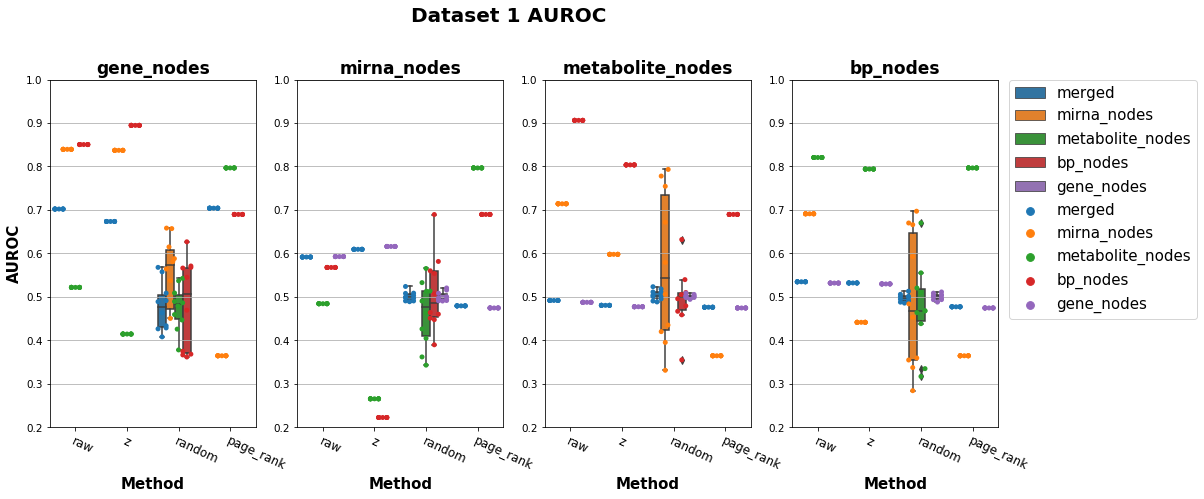

In [21]:
show_sb_box_plot(data_dict=preprocess_for_sb_boxplot(metrics_by_method_entity_ordered['auroc']['Dataset 1']),
                 x_label='Method',
                 y_label='AUROC',
                 y_lim = [0.2, 1],
                 title = 'Dataset 1 AUROC'
                )


/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


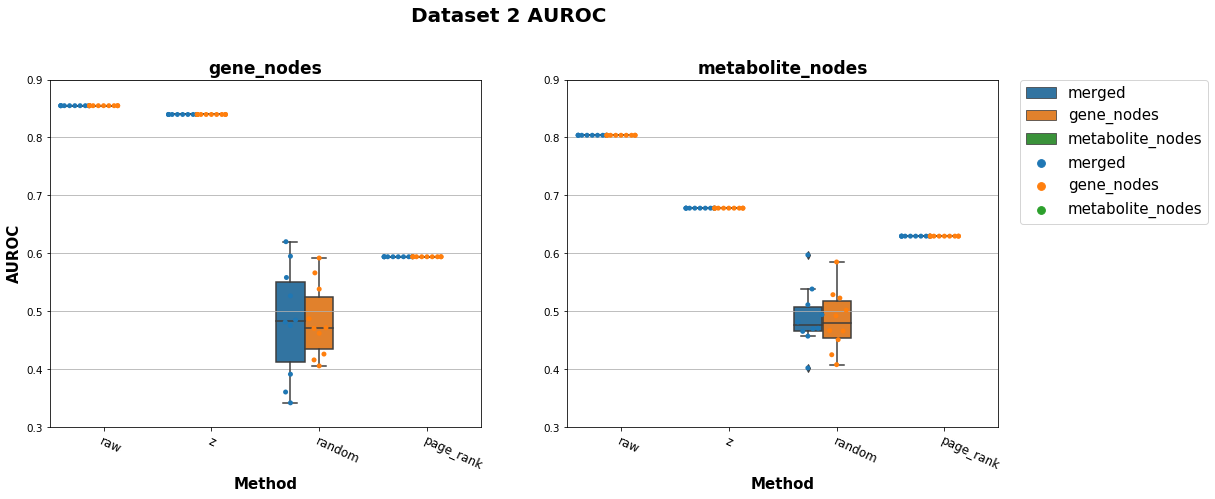

In [22]:
show_sb_box_plot(data_dict=preprocess_for_sb_boxplot(metrics_by_method_entity_integrated['auroc']['Dataset 2']),
                 x_label='Method',
                 y_label='AUROC',
                 y_lim = [0.3, 0.9],
                 title = 'Dataset 2 AUROC'
                )


/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


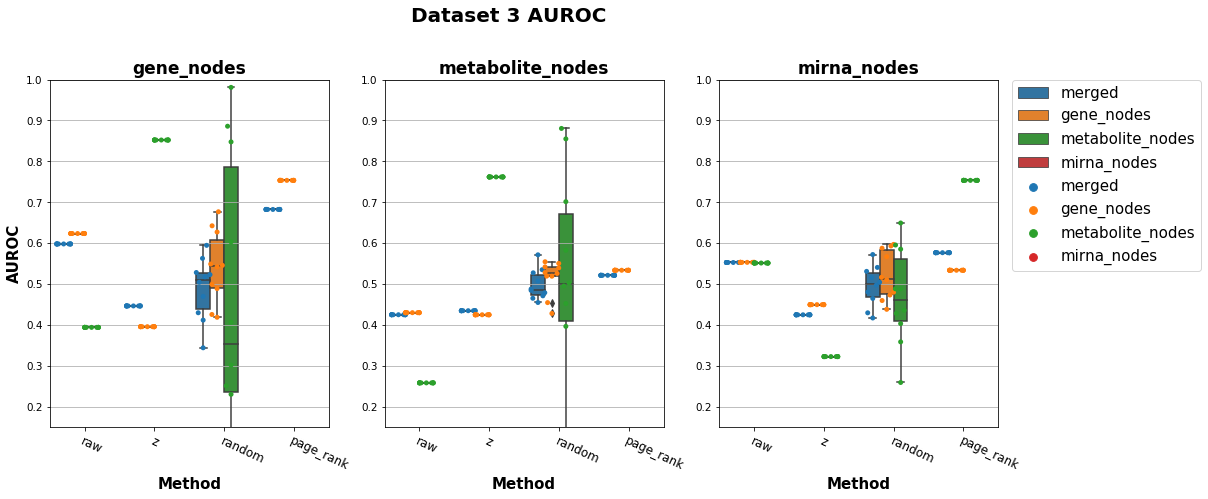

In [23]:
show_sb_box_plot(data_dict=preprocess_for_sb_boxplot(metrics_by_method_entity_integrated['auroc']['Dataset 3']),
                 x_label='Method',
                 y_label='AUROC',
                 y_lim = [0.15, 1],
                 title = 'Dataset 3 AUROC'
                )


In [140]:
df_wilcoxon = get_wilcoxon_test(preprocess_for_sb_ttest(metrics_by_method_entity_integrated['auroc']), True, "AUROC")
df_wilcoxon.style.hide_index()

Dataset,Comparison AUROC,p_value,Significant difference
Dataset 1,"('raw_on_integrated_graph', 'z_on_integrated_graph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'random_on_integrated_graph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'page_rank_on_integrated_graph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'raw_on_gene_subgraph')",0.369504,False
Dataset 1,"('raw_on_integrated_graph', 'z_on_gene_subgraph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'random_on_gene_subgraph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'page_rank_on_gene_subgraph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'raw_on_metabolite_subgraph')",3.43391e-17,True
Dataset 1,"('raw_on_integrated_graph', 'z_on_metabolite_subgraph')",0.0247536,False
Dataset 1,"('raw_on_integrated_graph', 'random_on_metabolite_subgraph')",1.54659e-17,True


### 4.2. Metrics AUPRC

#### Dataset 1

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


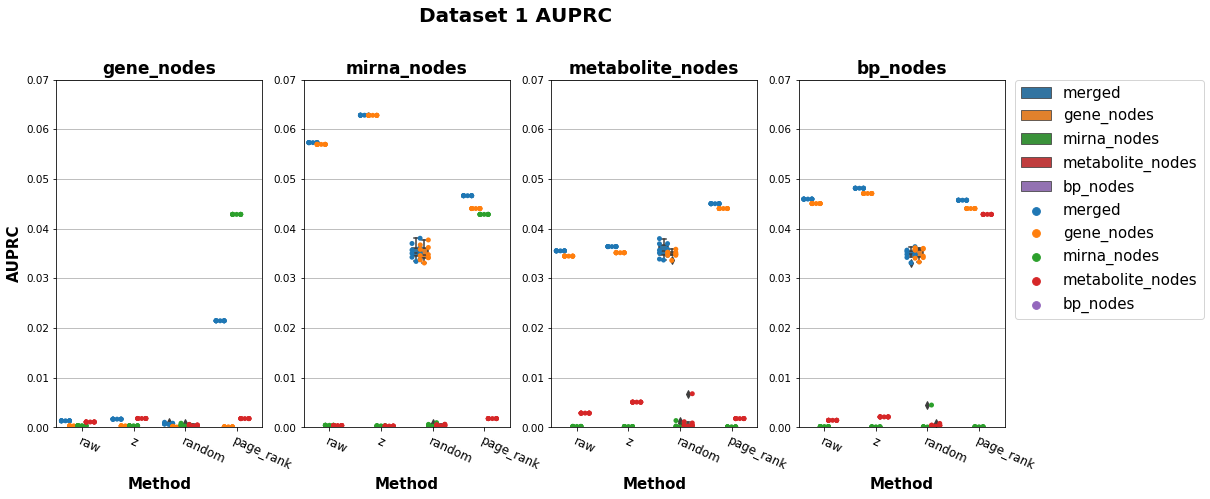

In [16]:
show_sb_box_plot(data_dict=preprocess_for_sb_boxplot(metrics_by_method_entity_integrated['auprc']['Dataset 1']),
                 x_label='Method',
                 y_label='AUPRC',
                 y_lim = [0, 0.07],
                 title = 'Dataset 1 AUPRC'
                )

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


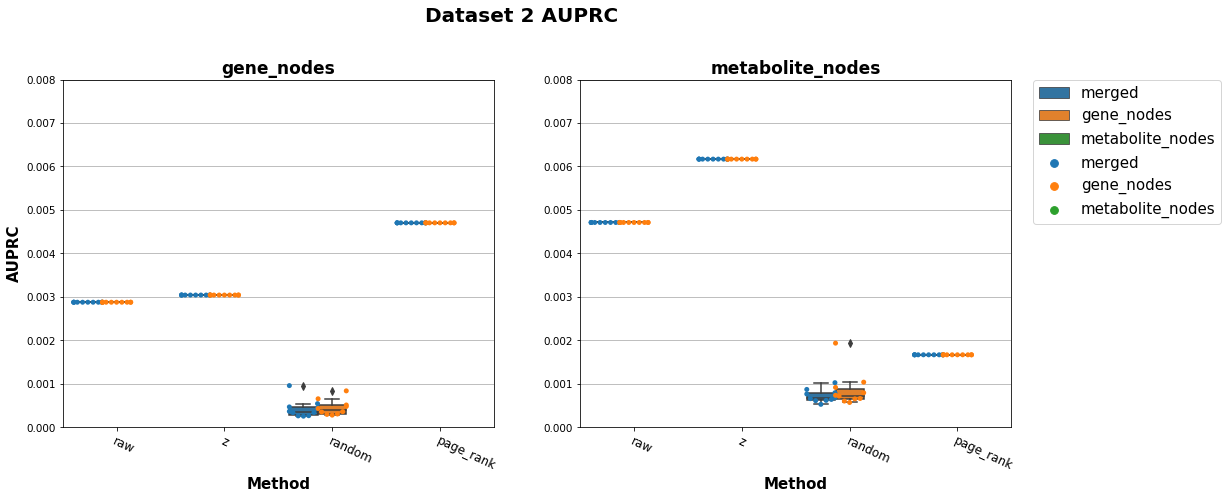

In [18]:
show_sb_box_plot(data_dict=preprocess_for_sb_boxplot(metrics_by_method_entity_integrated['auprc']['Dataset 2']),
                 x_label='Method',
                 y_label='AUPRC',
                 y_lim = [0, 0.008],
                 title = 'Dataset 2 AUPRC'
                )

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


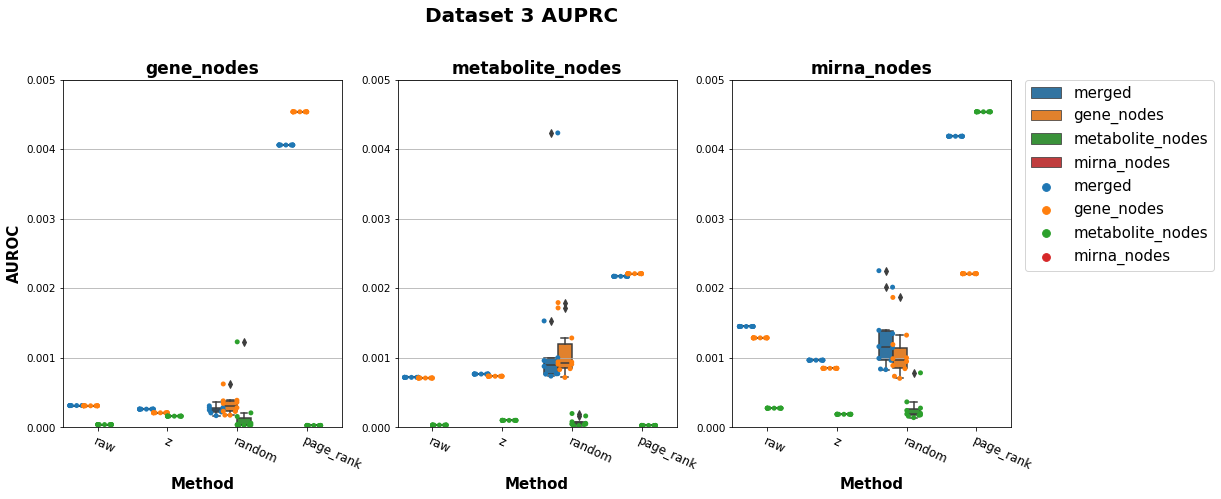

In [20]:
show_sb_box_plot(data_dict=preprocess_for_sb_boxplot(metrics_by_method_entity_integrated['auprc']['Dataset 3']),
                 x_label='Method',
                 y_label='AUROC',
                 y_lim = [0, 0.005],
                 title = 'Dataset 3 AUPRC'
                )